# Prototyping with convolutional embedders

This notebook aims to demonstrate the logic of what we want to do, and how to access data. For that purpose, it is using pretty basic architectures and small amount of compute.


In [1]:
%pylab inline

from datasets import load_dataset

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Accessing the data

The data is available as a Hugging Face dataset, which is already pre-compiled and available on Rusty if you follow these steps:

In [2]:
dataset = load_dataset('../astroclip/datasets/legacy_survey.py', cache_dir='/mnt/home/flanusse/ceph/huggingface/datasets')

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'spectrum', 'redshift'],
        num_rows: 158380
    })
    test: Dataset({
        features: ['image', 'spectrum', 'redshift'],
        num_rows: 39596
    })
})

So, the dataset contains 2 splits, one for training, one for testing. And each split contains images, spectra, and additional information about the object like its redshift.

Let's have a look at a few examples:

In [4]:
"""
Transformation from raw image data (nanomaggies) to the rgb values displayed
at the legacy viewer https://www.legacysurvey.org/viewer
Code copied from
https://github.com/legacysurvey/imagine/blob/master/map/views.py
"""
def dr2_rgb(imgs, bands=['g','r','z'], scales=dict(g=(2,6.0), r=(1,3.4), z=(0,2.2)), m=0.03):
    import numpy as np
    rgbscales = {'u': (2,1.5),  'g': (2,2.5), 'r': (1,1.5),  'i': (0,1.0), 'z': (0,0.4)}
    if scales is not None:
        rgbscales.update(scales)
    I = 0
    for img,band in zip(imgs, bands):
        plane,scale = rgbscales[band]
        img = np.maximum(0, img * scale + m)
        I = I + img
    I /= len(bands)
    Q = 20
    fI = np.arcsinh(Q * I) / np.sqrt(Q)
    I += (I == 0.) * 1e-6
    H,W = I.shape
    rgb = np.zeros((H,W,3), np.float32)
    for img,band in zip(imgs, bands):
        plane,scale = rgbscales[band]
        rgb[:,:,plane] = (img * scale + m) * fI / I
    rgb = np.clip(rgb, 0, 1)
    return rgb

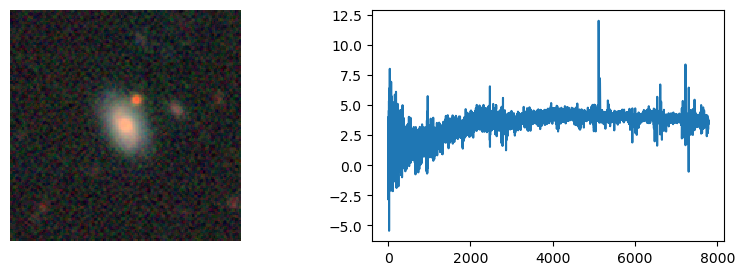

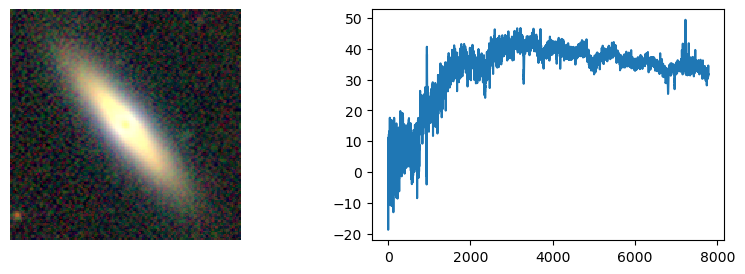

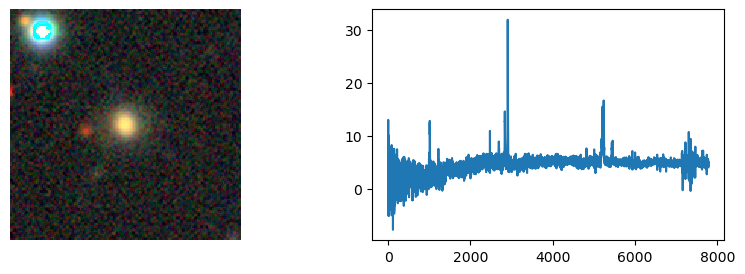

In [5]:
for i in range(3):
    # Extract example from dataset
    example = dataset['train'][i]
    
    figure(figsize=[10,3])
    subplot(121)
    imshow(dr2_rgb(np.array(example['image']).T), interpolation='none')
    axis('off')
    subplot(122)
    plot(np.array(example['spectrum']).flatten())

In [6]:
np.array(example['image']).shape, np.array(example['spectrum']).shape

((152, 152, 3), (7781, 1))

So, here we see what the data looks like. 152x152x3 images and 7781 spectra.

## Building embedding architectures

### Baseline 1D spectrum embedder

Before we get started, let's build an embedding model using a recently published SOTA model for spectra https://arxiv.org/abs/2307.07664

This is a convolutional architecture, with some self attention, and should be a good baseline.

Code is from here: https://github.com/pmelchior/spender/blob/main/spender/model.py

In [7]:
import torch
from torch import nn

In [12]:
class MLP(nn.Sequential):
    """Multi-Layer Perceptron

    A simple implementation with a configurable number of hidden layers and
    activation functions.

    Parameters
    ----------
    n_in: int
        Input dimension
    n_out: int
        Output dimension
    n_hidden: list of int
        Dimensions for every hidden layer
    act: list of callables
        Activation functions after every layer. Needs to have len(n_hidden) + 1
        If `None`, will be set to `LeakyReLU` for every layer.
    dropout: float
        Dropout probability
    """

    def __init__(self, n_in, n_out, n_hidden=(16, 16, 16), act=None, dropout=0):

        if act is None:
            act = [
                nn.LeakyReLU(),
            ] * (len(n_hidden) + 1)
        assert len(act) == len(n_hidden) + 1

        layer = []
        n_ = [n_in, *n_hidden, n_out]
        for i in range(len(n_) - 1):
            layer.append(nn.Linear(n_[i], n_[i + 1]))
            layer.append(act[i])
            layer.append(nn.Dropout(p=dropout))

        super(MLP, self).__init__(*layer)


class SpectrumEncoder(nn.Module):
    """Spectrum encoder

    Modified version of the encoder by Serrà et al. (2018), which combines a 3 layer CNN
    with a dot-product attention module. This encoder adds a MLP to further compress the
    attended values into a low-dimensional latent space.

    Paper: Serrà et al., https://arxiv.org/abs/1805.03908

    Parameters
    ----------
    instrument: :class:`spender.Instrument`
        Instrument that observed the data
    n_latent: int
        Dimension of latent space
    n_hidden: list of int
        Dimensions for every hidden layer of the :class:`MLP`
    act: list of callables
        Activation functions after every layer. Needs to have len(n_hidden) + 1
        If `None`, will be set to `LeakyReLU` for every layer.
    dropout: float
        Dropout probability
    """

    def __init__(
        self, instrument, n_latent, n_hidden=(128, 64, 32), act=None, dropout=0
    ):

        super(SpectrumEncoder, self).__init__()
        self.instrument = instrument
        self.n_latent = n_latent
        
        filters = [128, 256, 512]
        sizes = [5, 11, 21]
        self.conv1, self.conv2, self.conv3 = self._conv_blocks(
            filters, sizes, dropout=dropout
        )
        self.n_feature = filters[-1] // 2

        # pools and softmax work for spectra and weights
        self.pool1, self.pool2 = tuple(
            nn.MaxPool1d(s, padding=s // 2) for s in sizes[:2]
        )
        self.softmax = nn.Softmax(dim=-1)

        # small MLP to go from CNN features to latents
        if act is None:
            act = [nn.PReLU(n) for n in n_hidden]
            # last activation identity to have latents centered around 0
            act.append(nn.Identity())
        self.mlp = MLP(self.n_feature, self.n_latent, n_hidden=n_hidden, act=act, dropout=dropout)

    def _conv_blocks(self, filters, sizes, dropout=0):
        convs = []
        for i in range(len(filters)):
            f_in = 1 if i == 0 else filters[i - 1]
            f = filters[i]
            s = sizes[i]
            p = s // 2
            conv = nn.Conv1d(
                in_channels=f_in,
                out_channels=f,
                kernel_size=s,
                padding=p,
            )
            norm = nn.InstanceNorm1d(f)
            act = nn.PReLU(f)
            drop = nn.Dropout(p=dropout)
            convs.append(nn.Sequential(conv, norm, act, drop))
        return tuple(convs)

    def _downsample(self, x):
        # compression
        x = x.unsqueeze(1)
        x = self.pool1(self.conv1(x))
        x = self.pool2(self.conv2(x))
        x = self.conv3(x)
        C = x.shape[1] // 2
        # split half channels into attention value and key
        h, a = torch.split(x, [C, C], dim=1)

        return h, a

    def forward(self, y):
        """Forward method

        Parameters
        ----------
        y: `torch.tensor`, shape (N, L)
            Batch of observed spectra

        Returns
        -------
        s: `torch.tensor`, shape (N, n_latent)
            Batch of latents that encode `spectra`
        """
        # run through CNNs
        h, a = self._downsample(y)
        # softmax attention
        a = self.softmax(a)

        # attach hook to extract backward gradient of a scalar prediction
        # for Grad-FAM (Feature Activation Map)
        if ~self.training and a.requires_grad == True:
            a.register_hook(self._attention_hook)

        # apply attention
        x = torch.sum(h * a, dim=2)

        # run attended features into MLP for final latents
        x = self.mlp(x)
        return x

    @property
    def n_parameters(self):
        """Number of parameters in this model"""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def _attention_hook(self, grad):
        self._attention_grad = grad

    @property
    def attention_grad(self):
        """Gradient of the attention weights

        Factor to compute the importance of attention for Grad-FAM method.

        Requires a previous `loss.backward` call for any scalar loss function based on
        outputs of this class's `forward` method. This functionality is switched off
        during training.
        """
        if hasattr(self, "_attention_grad"):
            return self._attention_grad
        else:
            return None

In [13]:
model = SpectrumEncoder(None, 1)

In [15]:
dataset.set_format(type='torch', columns=['spectrum', 'redshift'])
dataloader = torch.utils.data.DataLoader(dataset['train'], batch_size=256, shuffle=True)

In [18]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

learning_rate = 1e-3
epochs = 5

model = model.to('cuda')
criterion = nn.MSELoss().to('cuda')
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

losses = []
model.train()

for epoch in range(epochs):  # loop over the dataset multiple times
    
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data['spectrum'].reshape([-1,7781]).to('cuda'), data['redshift'].to('cuda')

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs[:,0], labels)
        
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        # print
        if i % 10 == 0:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {loss.item():.3f}')
            
    scheduler.step()

[1,     1] loss: 0.101
[1,    11] loss: 0.028
[1,    21] loss: 0.020
[1,    31] loss: 0.025
[1,    41] loss: 0.009
[1,    51] loss: 0.016
[1,    61] loss: 0.014
[1,    71] loss: 0.006
[1,    81] loss: 0.015
[1,    91] loss: 0.022
[1,   101] loss: 0.005
[1,   111] loss: 0.010
[1,   121] loss: 0.012
[1,   131] loss: 0.005
[1,   141] loss: 0.007
[1,   151] loss: 0.013
[1,   161] loss: 0.003
[1,   171] loss: 0.014
[1,   181] loss: 0.029
[1,   191] loss: 0.011
[1,   201] loss: 0.004
[1,   211] loss: 0.013
[1,   221] loss: 0.006
[1,   231] loss: 0.015
[1,   241] loss: 0.017
[1,   251] loss: 0.027
[1,   261] loss: 0.003
[1,   271] loss: 0.003
[1,   281] loss: 0.003
[1,   291] loss: 0.026
[1,   301] loss: 0.005
[1,   311] loss: 0.018
[1,   321] loss: 0.007
[1,   331] loss: 0.017
[1,   341] loss: 0.004
[1,   351] loss: 0.011
[1,   361] loss: 0.015
[1,   371] loss: 0.008
[1,   381] loss: 0.030
[1,   391] loss: 0.022
[1,   401] loss: 0.009
[1,   411] loss: 0.022
[1,   421] loss: 0.011
[1,   431] 

KeyboardInterrupt: 

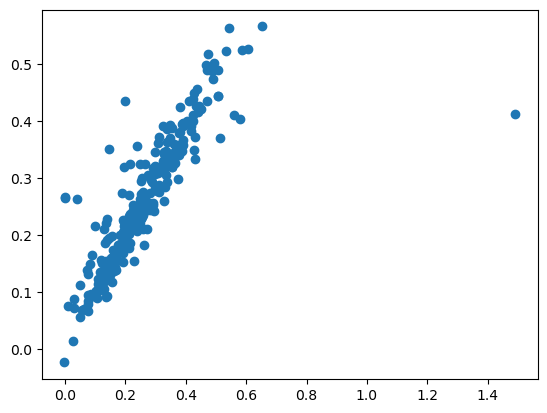

In [20]:
scatter(labels.cpu().detach().numpy(), 
        model(inputs).cpu().detach().numpy()[:,0], )

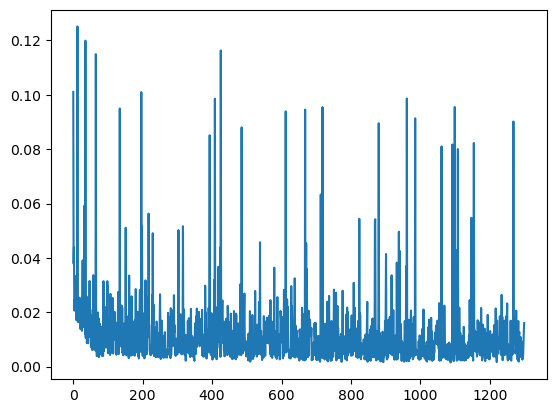

In [21]:
plot(losses)

Let's use a simple ConvNeXt model as our baseline architecture for this notebook. The benefit here is that it should work trivially well for spectra, whereas we would need to think a bit more to build a transformer-based model for them.

In [19]:
# These pieces of code are directly taken from the convnext repo: https://github.com/facebookresearch/ConvNeXt-V2
import torch
import torch.nn as nn
import torch.nn.functional as F
from timm.models.layers import trunc_normal_

class LayerNorm(nn.Module):
    """ LayerNorm that supports two data formats: channels_last (default) or channels_first. 
    The ordering of the dimensions in the inputs. channels_last corresponds to inputs with 
    shape (batch_size, height, width, channels) while channels_first corresponds to inputs 
    with shape (batch_size, channels, height, width).
    """
    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_last"):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise NotImplementedError 
        self.normalized_shape = (normalized_shape, )
    
    def forward(self, x):
        if self.data_format == "channels_last":
            return F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        elif self.data_format == "channels_first":
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = self.weight[:, None, None] * x + self.bias[:, None, None]
            return x

class GRN(nn.Module):
    """ GRN (Global Response Normalization) layer
    """
    def __init__(self, dim):
        super().__init__()
        self.gamma = nn.Parameter(torch.zeros(1, 1, 1, dim))
        self.beta = nn.Parameter(torch.zeros(1, 1, 1, dim))

    def forward(self, x):
        Gx = torch.norm(x, p=2, dim=(1,2), keepdim=True)
        Nx = Gx / (Gx.mean(dim=-1, keepdim=True) + 1e-6)
        return self.gamma * (x * Nx) + self.beta + x
    
class Block(nn.Module):
    """ ConvNeXtV2 Block.
    
    Args:
        dim (int): Number of input channels.
        drop_path (float): Stochastic depth rate. Default: 0.0
    """
    def __init__(self, dim, drop_path=0.):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim) # depthwise conv
        self.norm = LayerNorm(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(dim, 4 * dim) # pointwise/1x1 convs, implemented with linear layers
        self.act = nn.GELU()
        self.grn = GRN(4 * dim)
        self.pwconv2 = nn.Linear(4 * dim, dim)
        self.drop_path = nn.Identity()

    def forward(self, x):
        input = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1) # (N, C, H, W) -> (N, H, W, C)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.grn(x)
        x = self.pwconv2(x)
        x = x.permute(0, 3, 1, 2) # (N, H, W, C) -> (N, C, H, W)

        x = input + self.drop_path(x)
        return x

class ConvNeXtV2(nn.Module):
    """ ConvNeXt V2
        
    Args:
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        depths (tuple(int)): Number of blocks at each stage. Default: [3, 3, 9, 3]
        dims (int): Feature dimension at each stage. Default: [96, 192, 384, 768]
        drop_path_rate (float): Stochastic depth rate. Default: 0.
        head_init_scale (float): Init scaling value for classifier weights and biases. Default: 1.
    """
    def __init__(self, in_chans=3, num_classes=1000, 
                 depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], 
                 drop_path_rate=0., head_init_scale=1.
                 ):
        super().__init__()
        self.depths = depths
        self.downsample_layers = nn.ModuleList() # stem and 3 intermediate downsampling conv layers
        stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=4, stride=4),
            LayerNorm(dims[0], eps=1e-6, data_format="channels_first")
        )
        self.downsample_layers.append(stem)
        for i in range(3):
            downsample_layer = nn.Sequential(
                    LayerNorm(dims[i], eps=1e-6, data_format="channels_first"),
                    nn.Conv2d(dims[i], dims[i+1], kernel_size=2, stride=2),
            )
            self.downsample_layers.append(downsample_layer)

        self.stages = nn.ModuleList() # 4 feature resolution stages, each consisting of multiple residual blocks
        dp_rates=[x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))] 
        cur = 0
        for i in range(4):
            stage = nn.Sequential(
                *[Block(dim=dims[i], drop_path=dp_rates[cur + j]) for j in range(depths[i])]
            )
            self.stages.append(stage)
            cur += depths[i]

        self.norm = nn.LayerNorm(dims[-1], eps=1e-6) # final norm layer
        self.head = nn.Linear(dims[-1], num_classes)

        self.apply(self._init_weights)
        self.head.weight.data.mul_(head_init_scale)
        self.head.bias.data.mul_(head_init_scale)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            trunc_normal_(m.weight, std=.02)
            nn.init.constant_(m.bias, 0)

    def forward_features(self, x):
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)
        return self.norm(x.mean([-2, -1])) # global average pooling, (N, C, H, W) -> (N, C)

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x

In [105]:
class GRN1D(nn.Module):
    """ GRN (Global Response Normalization) layer
    """
    def __init__(self, dim):
        super().__init__()
        self.gamma = nn.Parameter(torch.zeros(1, 1, dim))
        self.beta = nn.Parameter(torch.zeros(1, 1, dim))

    def forward(self, x):
        Gx = torch.norm(x, p=2, dim=(1,), keepdim=True)
        Nx = Gx / (Gx.mean(dim=-1, keepdim=True) + 1e-6)
        return self.gamma * (x * Nx) + self.beta + x
    
class LayerNorm1D(nn.Module):
    """ LayerNorm that supports two data formats: channels_last (default) or channels_first. 
    The ordering of the dimensions in the inputs. channels_last corresponds to inputs with 
    shape (batch_size, height, width, channels) while channels_first corresponds to inputs 
    with shape (batch_size, channels, height, width).
    """
    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_last"):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise NotImplementedError 
        self.normalized_shape = (normalized_shape, )
    
    def forward(self, x):
        if self.data_format == "channels_last":
            return F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        elif self.data_format == "channels_first":
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = self.weight[:, None] * x + self.bias[:, None]
            return x

class Block1D(nn.Module):
    """ ConvNeXtV2 Block but in 1D.
    
    Args:
        dim (int): Number of input channels.
        drop_path (float): Stochastic depth rate. Default: 0.0
    """
    def __init__(self, dim, drop_path=0.):
        super().__init__()
        self.dwconv = nn.Conv1d(dim, dim, kernel_size=7, padding=3, groups=dim) # depthwise conv
        self.norm = LayerNorm1D(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(dim, 4 * dim) # pointwise/1x1 convs, implemented with linear layers
        self.act = nn.GELU()
        self.grn = GRN1D(4 * dim)
        self.pwconv2 = nn.Linear(4 * dim, dim)
        self.drop_path = nn.Identity()

    def forward(self, x):
        input = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 1) # (N, C, W) -> (N, W, C)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.grn(x)
        x = self.pwconv2(x)
        x = x.permute(0, 2, 1) # (N, W, C) -> (N, C, W)

        x = input + self.drop_path(x)
        return x

class ConvNeXtV21D(nn.Module):
    """ ConvNeXt V2 but in 1D
        
    Args:
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        depths (tuple(int)): Number of blocks at each stage. Default: [3, 3, 9, 3]
        dims (int): Feature dimension at each stage. Default: [96, 192, 384, 768]
        drop_path_rate (float): Stochastic depth rate. Default: 0.
        head_init_scale (float): Init scaling value for classifier weights and biases. Default: 1.
    """
    def __init__(self, in_chans=1, num_classes=1000, 
                 depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], 
                 drop_path_rate=0., head_init_scale=1.
                 ):
        super().__init__()
        self.depths = depths
        self.downsample_layers = nn.ModuleList() # stem and 3 intermediate downsampling conv layers
        stem = nn.Sequential(
            nn.Conv1d(in_chans, dims[0], kernel_size=4, stride=4),
            LayerNorm1D(dims[0], eps=1e-6, data_format="channels_first")
        )
        self.downsample_layers.append(stem)
        for i in range(3):
            downsample_layer = nn.Sequential(
                    LayerNorm1D(dims[i], eps=1e-6, data_format="channels_first"),
                    nn.Conv1d(dims[i], dims[i+1], kernel_size=4, stride=4),
            )
            self.downsample_layers.append(downsample_layer)

        self.stages = nn.ModuleList() # 4 feature resolution stages, each consisting of multiple residual blocks
        dp_rates=[x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))] 
        cur = 0
        for i in range(4):
            stage = nn.Sequential(
                *[Block1D(dim=dims[i], drop_path=dp_rates[cur + j]) for j in range(depths[i])]
            )
            self.stages.append(stage)
            cur += depths[i]
            
        # We will see if this is necessary or not...
        self.down = nn.Conv1d(dims[-1], dims[-1], kernel_size=6, stride=6)
        self.down_lin = nn.Linear(dims[-1]*5, dims[-1])
        self.norm = nn.LayerNorm(dims[-1], eps=1e-6) # final norm layer
        self.head = nn.Linear(dims[-1], num_classes)

        self.apply(self._init_weights)
        self.head.weight.data.mul_(head_init_scale)
        self.head.bias.data.mul_(head_init_scale)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv1d, nn.Linear)):
            trunc_normal_(m.weight, std=.02)
            nn.init.constant_(m.bias, 0)

    def forward_features(self, x):
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)
        x = self.down(x)
        x = torch.flatten(x, start_dim=1)
        x = self.down_lin(x)
        return self.norm(x) # global average pooling, (N, C, W) -> (N, C)

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x

In [106]:
def convnextv21d_atto(**kwargs):
    model = ConvNeXtV21D(depths=[2, 2, 6, 2], dims=[40, 80, 160, 320], **kwargs)
    return model

In [107]:
model = convnextv21d_atto()

In [108]:
model = model.to('cuda')

In [109]:
model.forward_features(torch.from_numpy(np.array(example['spectrum']).reshape([1,1,-1]).astype('float32')).to('cuda')).shape

torch.Size([1, 320])

In [110]:
torch.from_numpy(np.array(example['spectrum']).reshape([1,1,-1]).astype('float32')).to('cuda')

tensor([[[ 4.3060, -1.3159,  5.4897,  ...,  4.5651,  5.1925,  4.0626]]],
       device='cuda:0')

## Validating Spectrum Encoder of redshift estimation task

The most very basic thing that we would ask of a network looking at spectra is to be able to estimate the redshift of galaxies. By testing our 1D encoder on this task we can see if the model is sentitive to both global and local features.

In [111]:
model_redshift = convnextv21d_atto(num_classes=1).to('cuda')

In [124]:
dataset.set_format(type='torch', columns=['spectrum', 'redshift'])
dataloader = torch.utils.data.DataLoader(dataset['train'], batch_size=256, shuffle=True)

In [125]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

learning_rate = 1e-3
epochs = 5

criterion = nn.MSELoss().to('cuda')
optimizer = optim.AdamW(model_redshift.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

losses = []
model_redshift.train()

for epoch in range(epochs):  # loop over the dataset multiple times
    
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data['spectrum'].reshape([-1,1,7781]).to('cuda'), data['redshift'].to('cuda')

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model_redshift(inputs)
        loss = criterion(outputs[:,0], labels)
        
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        # print
        if i % 10 == 0:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {loss.item():.3f}')
            
    scheduler.step()

[1,     1] loss: 0.034
[1,    11] loss: 0.029
[1,    21] loss: 0.019
[1,    31] loss: 0.027
[1,    41] loss: 0.020
[1,    51] loss: 0.040
[1,    61] loss: 0.027
[1,    71] loss: 0.017
[1,    81] loss: 0.016
[1,    91] loss: 0.023
[1,   101] loss: 0.018
[1,   111] loss: 0.015
[1,   121] loss: 0.025
[1,   131] loss: 0.022
[1,   141] loss: 0.052
[1,   151] loss: 0.027
[1,   161] loss: 0.025
[1,   171] loss: 0.029
[1,   181] loss: 0.033
[1,   191] loss: 0.018
[1,   201] loss: 0.035
[1,   211] loss: 0.025
[1,   221] loss: 0.031
[1,   231] loss: 0.023
[1,   241] loss: 0.019
[1,   251] loss: 0.017
[1,   261] loss: 0.027
[1,   271] loss: 0.018
[1,   281] loss: 0.023
[1,   291] loss: 0.032
[1,   301] loss: 0.113
[1,   311] loss: 0.023
[1,   321] loss: 0.026
[1,   331] loss: 0.024
[1,   341] loss: 0.018
[1,   351] loss: 0.035
[1,   361] loss: 0.033
[1,   371] loss: 0.019
[1,   381] loss: 0.019
[1,   391] loss: 0.111
[1,   401] loss: 0.027
[1,   411] loss: 0.030
[1,   421] loss: 0.028
[1,   431] 

KeyboardInterrupt: 

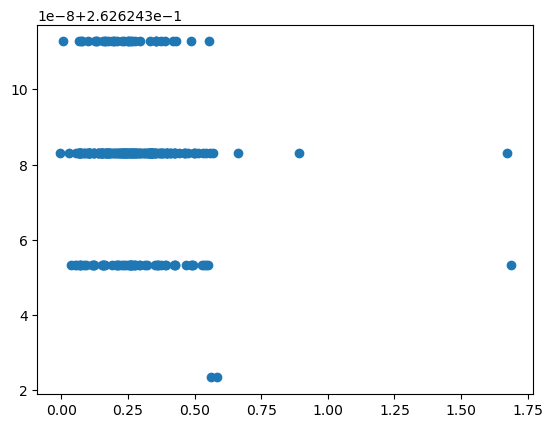

In [126]:
scatter(labels.cpu().detach().numpy(), 
        model_redshift(inputs).cpu().detach().numpy()[:,0], )

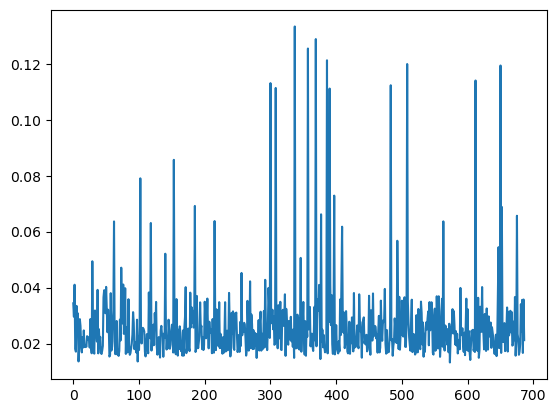

In [127]:
plot(losses)